# T5 English to Portuguese translate
## Name: Rafael Gonçalves

## Configuration

In [0]:
# Configurações gerais
model_name = "t5-small"
use_cuda = True

In [0]:
! pip install --quiet sacrebleu
! pip install --quiet pytorch-lightning==0.7.5
! pip install --quiet transformers

In [3]:
# Importar todos os pacotes de uma só vez para evitar duplicados ao longo do notebook.
import gzip
import nvidia_smi
import os, functools
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import random
import sacrebleu
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from multiprocessing import cpu_count

from google.colab import drive

from pytorch_lightning.callbacks import ModelCheckpoint

from transformers import T5ForConditionalGeneration
from transformers import T5Tokenizer

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from typing import Dict
from typing import List
from typing import Tuple

INFO:transformers.file_utils:PyTorch version 1.5.0+cu101 available.
INFO:transformers.file_utils:TensorFlow version 2.2.0 available.


In [0]:
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None

    return wrapper

In [0]:
# Important: Fix seeds so we can replicate results
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [6]:
print(f"Pytorch Lightning Version: {pl.__version__}")
if use_cuda:
    nvidia_smi.nvmlInit()
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    print(f"Device name: {nvidia_smi.nvmlDeviceGetName(handle)}")

nproc = cpu_count()
print('CPU cores:', nproc)
def gpu_usage():
    global handle
    return str(nvidia_smi.nvmlDeviceGetUtilizationRates(handle).gpu) + '%'

Pytorch Lightning Version: 0.7.5
Device name: b'Tesla P100-PCIE-16GB'
CPU cores: 4


In [0]:
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use('ggplot')

In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prepare data

In [9]:
# Download dataset
! wget -nc https://storage.googleapis.com/neuralresearcher_data/unicamp/ia376e_2020s1/paracrawl_enpt_train.tsv.gz
! wget -nc https://storage.googleapis.com/neuralresearcher_data/unicamp/ia376e_2020s1/paracrawl_enpt_test.tsv.gz

File ‘paracrawl_enpt_train.tsv.gz’ already there; not retrieving.

File ‘paracrawl_enpt_test.tsv.gz’ already there; not retrieving.



In [10]:
# Load dataset
def load_text_pairs(path):
    text_pairs = []
    for line in gzip.open(path, mode='rt'):
        text_pairs.append(line.strip().split('\t'))
    return text_pairs

x_train = load_text_pairs('paracrawl_enpt_train.tsv.gz')
x_test = load_text_pairs('paracrawl_enpt_test.tsv.gz')

# Embaralhamos o treino para depois fazermos a divisão treino/val.
random.shuffle(x_train)

# Truncamos o dataset para 100k pares de treino e 5k pares de validação.
x_val = x_train[100000:105000]
x_train = x_train[:100000]

for set_name, x in [('treino', x_train), ('validação', x_val), ('test', x_test)]:
    print(f'\n{len(x)} amostras de {set_name}')
    print(f'3 primeiras amostras {set_name}:')
    for i, (source, target) in enumerate(x[:3]):
        print(f'{i}: source: {source}\n   target: {target}')


100000 amostras de treino
3 primeiras amostras treino:
0: source: Home > Plastic Masterbatches > Rubber Carbon Black Masterbatch with Competitive Price
   target: Home > Masterbatches plásticos > Masterbatch enchimento plástico para pe sacola de compras
1: source: They are very good these baths after a day of intense sports such as Ski and Snowboard, helps recovery from fractures and muscle injuries because it has an analgesic and anti- inflammatory effect
   target: Eles são muito bons estes banhos após um dia de esportes intensos , como Ski e Snowboard , ajuda a recuperação de fraturas e lesões musculares , pois tem um efeito analgésico e anti- inflamatório.
2: source: Many say to me, as you yourselves have, that ‘there is no time where you are’, yet I do not believe you do not understand ‘our time’.
   target: Muitas pessoas me dizem, como vocês próprios já me disseram, que ‘não existe tempo onde vocês estão’, mas não creio que vocês não entendam ‘o nosso tempo’.

5000 amostras de 

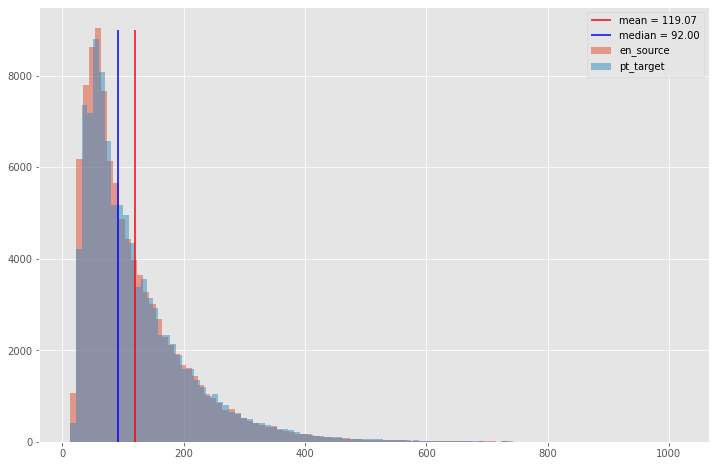

In [11]:
a, b = [len(e[0]) for e in x_train], [len(e[1]) for e in x_train]
c = a + b
counts, bins = np.histogram(a, 100)
counts1, bins1 = np.histogram(b, 100)
plt.hist(bins[:-1], bins, weights=counts, alpha=0.5)
plt.hist(bins1[:-1], bins1, weights=counts1, alpha=0.5)
plt.vlines(np.mean(c), 0, 9000, color='r')
plt.vlines(np.median(c), 0, 9000, color='b')
plt.legend([f'mean = {np.mean(c):.2f}', f'median = {np.median(c):.2f}', 'en_source', 'pt_target'])
plt.plot()
plt.show()

## Dataset class

In [12]:
t5_tokenizer = T5Tokenizer.from_pretrained(model_name)

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


In [13]:
t5_tokenizer.get_vocab().keys()

dict_keys(['<pad>', '</s>', '<unk>', '▁', 'X', '.', ',', 's', '▁the', 'a', ':', '▁and', '▁to', '▁of', '▁fill', 'e', '▁in', 't', '-', '▁is', '▁de', '▁for', '’', 'i', '▁that', '▁you', 'd', '▁I', '▁with', 'n', '▁on', "'", 'o', '▁are', '▁it', 'en', '▁be', '▁The', '▁as', '▁your', 'l', '▁(', '▁or', '▁have', '▁at', '▁from', '▁an', '▁was', '▁this', 'er', '▁la', 'm', 'r', 'ing', '▁can', '!', '▁will', '▁by', '?', '▁not', 're', ')', '▁we', 'y', '▁und', '▁has', '▁all', '▁die', '▁but', '▁our', '▁their', '▁A', '▁more', '▁un', '▁der', 'c', 'u', 'in', '▁so', '▁they', '▁one', '▁about', '▁my', 'ul', '▁which', 'à', '▁In', '/', 'he', 'f', '▁le', '▁out', '▁also', '▁des', '▁It', '▁up', '▁"', '▁time', 'ă', 'if', '▁This', '▁We', 'p', '▁do', '–', '▁“', 'on', 'h', '▁si', 'le', '▁les', '▁în', '▁his', '▁who', '▁like', 'b', '▁when', ';', '▁been', '▁other', 'ly', '"', 'g', '▁cu', '▁care', '▁what', '▁new', 'or', '▁some', '▁get', '▁were', '▁just', '▁there', '▁would', 'S', '▁them', '▁any', ').', 'al', '▁into', '▁me', 

In [14]:
vocab_rev = {v: k for k, v in t5_tokenizer.get_vocab().items()}
for token in t5_tokenizer.encode('oi eu não sou o rafael gonçalves'):
    print(vocab_rev[token], end='-')

▁-o-i-▁-e-u-▁-n-<unk>-o-▁sou-▁-o-▁-r-a-f-a-e-l-▁-gon-ça-lves-

In [15]:
for token in t5_tokenizer.encode('ã à é ç ê é á ó í ú ô'):
    print(vocab_rev[token], end='-')

▁-<unk>-▁-à-▁-é-▁-ç-▁-ê-▁-é-▁-á-▁-ó-▁-<unk>-▁-<unk>-▁-ô-

In [16]:
t5_tokenizer.add_tokens(['Não', 'não', 'ão', 'ãe', 'õe', 'ãos', 'ães', 'ões', 'ílico', 'ílica', 'único', 'única'])

INFO:transformers.tokenization_utils:Adding Não to the vocabulary
INFO:transformers.tokenization_utils:Adding não to the vocabulary
INFO:transformers.tokenization_utils:Adding ão to the vocabulary
INFO:transformers.tokenization_utils:Adding ãe to the vocabulary
INFO:transformers.tokenization_utils:Adding õe to the vocabulary
INFO:transformers.tokenization_utils:Adding ãos to the vocabulary
INFO:transformers.tokenization_utils:Adding ães to the vocabulary
INFO:transformers.tokenization_utils:Adding ões to the vocabulary
INFO:transformers.tokenization_utils:Adding ílico to the vocabulary
INFO:transformers.tokenization_utils:Adding ílica to the vocabulary
INFO:transformers.tokenization_utils:Adding único to the vocabulary
INFO:transformers.tokenization_utils:Adding única to the vocabulary


12

In [17]:
vocab_rev = {v: k for k, v in t5_tokenizer.get_vocab().items()}
input_ids = t5_tokenizer.encode_plus(text='oi eu não sou o rafael gonçalves')['input_ids']
for token in input_ids:
    print(vocab_rev[token], end='-')
print(t5_tokenizer.decode(input_ids))

▁-o-i-▁-e-u-▁-n-ão-▁sou-▁-o-▁-r-a-f-a-e-l-▁-gon-ça-lves-oi eu n ão sou o rafael gonçalves


In [18]:
t5_tokenizer.encode_plus('translate English to Portuguese:')

{'input_ids': [13959, 1566, 12, 21076, 10], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [0]:
def pad_collate(batch):
    source_ids, source_attn_mask, target_ids, target_attn_mask, source, target = zip(*batch)

    pad = t5_tokenizer.pad_token_id

    source_pad = torch.nn.utils.rnn.pad_sequence(source_ids, batch_first=True, padding_value=pad)
    source_mask = torch.nn.utils.rnn.pad_sequence(source_attn_mask, batch_first=True, padding_value=0)
    target_pad = torch.nn.utils.rnn.pad_sequence(target_ids, batch_first=True, padding_value=pad)
    target_mask = torch.nn.utils.rnn.pad_sequence(target_attn_mask, batch_first=True, padding_value=0)

    return source_pad, source_mask, target_pad, target_mask, source, target

In [0]:
# Dataset
class MyDataset(Dataset):
    def __init__(self, text_pairs: List[Tuple[str]], tokenizer = t5_tokenizer,
                 source_max_length: int = 128, target_max_length: int = 128):
        self.tokenizer = tokenizer
        self.text_pairs = sorted(text_pairs, key = lambda s: len(s[0]))
        #print(text_pairs, self.text_pairs)
        
        self.source_max_length = source_max_length
        self.target_max_length = target_max_length
        
    def __len__(self):
        return len(self.text_pairs)
    
    def __getitem__(self, idx):
        source, target = self.text_pairs[idx]
        

        dict_source = self.tokenizer.encode_plus(
            ' '.join(['translate English to Portuguese:', source, self.tokenizer.eos_token]),
            pad_to_max_length=False,
            max_length=self.source_max_length,
            return_attention_mask = True,
            return_token_type_ids=False,
            return_tensors='pt'
            )
        
        source_token_ids = dict_source['input_ids'][0]
        source_mask = dict_source['attention_mask'][0]

        dict_target = self.tokenizer.encode_plus(
            ' '.join([target, self.tokenizer.eos_token]),
            pad_to_max_length=False,
            max_length=self.target_max_length,
            return_attention_mask = True,
            return_token_type_ids=False,
            return_tensors='pt'
            )
        
        target_token_ids = dict_target['input_ids'][0]
        target_mask = dict_target['attention_mask'][0]

        return (source_token_ids, source_mask, target_token_ids, target_mask,
                source, target)

In [21]:
text_pairs = [('we like pizza', 'eu gosto de pizza'),
              ("we don't like pizza", 'eu não gosto de pizza')]
dataset_debug = MyDataset(
    text_pairs=text_pairs,
    tokenizer=t5_tokenizer,
    source_max_length=16,
    target_max_length=16)

dataloader_debug = DataLoader(dataset_debug, batch_size=8, shuffle=False, 
                              num_workers=0, collate_fn=pad_collate)

source_token_ids, source_mask, target_token_ids, target_mask, source, target = next(iter(dataloader_debug))
print('source_token_ids:\n', source_token_ids)
print('source_mask:\n', source_mask)
print('source_tokens:\n', t5_tokenizer.decode(source_token_ids[0]))
print('target_token_ids:\n', target_token_ids)
print('target_mask:\n', target_mask)
print('target_tokens:\n', t5_tokenizer.decode(target_token_ids[0]))

print('source_token_ids.shape:', source_token_ids.shape)
print('source_mask.shape:', source_mask.shape)
print('target_token_ids.shape:', target_token_ids.shape)
print('target_mask.shape:', target_mask.shape)

source_token_ids:
 tensor([[13959,  1566,    12, 21076,    10,    62,   114,  6871,     1,     0,
             0,     0],
        [13959,  1566,    12, 21076,    10,    62,   278,    31,    17,   114,
          6871,     1]])
source_mask:
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
source_tokens:
 translate English to Portuguese: we like pizza
target_token_ids:
 tensor([[    3,    15,    76,   281,     7,   235,    20,  6871,     1,     0,
             0,     0],
        [    3,    15,    76,     3,    29, 32102,   281,     7,   235,    20,
          6871,     1]])
target_mask:
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
target_tokens:
 eu gosto de pizza
source_token_ids.shape: torch.Size([2, 12])
source_mask.shape: torch.Size([2, 12])
target_token_ids.shape: torch.Size([2, 12])
target_mask.shape: torch.Size([2, 12])


## Model class

In [0]:
class T5Finetuner(pl.LightningModule):
    def __init__(self,
                 tokenizer = t5_tokenizer,
                 learning_rate = 1e-3,
                 batch_size=32,
                 source_max_length=128,
                 target_max_length=128,
                 weight_decay=0.001,
                 generate_strategy='greedy',
                 epochs = 5,
                 ):
        super(T5Finetuner, self).__init__()

        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        self.model.resize_token_embeddings(len(tokenizer))
        
        self.tokenizer = tokenizer
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.target_max_length = target_max_length
        self.source_max_length = source_max_length
        self.weight_decay = weight_decay
        self.generate_strategy = generate_strategy

        self.warmup_steps = 500
        self.training_steps = (epochs*len(x_train + x_val))/batch_size

        if use_cuda:
            self.pin_mem = True
            self.n_workers = 0
        else:
            self.pin_mem = False
            self.n_workers = nproc


    def prepare_data(self):
        self.train_data = MyDataset(
                text_pairs=x_train,
                tokenizer=self.tokenizer,
                source_max_length=self.source_max_length,
                target_max_length=self.target_max_length)
        
        self.valid_data = MyDataset(
                text_pairs=x_val,
                tokenizer=self.tokenizer,
                source_max_length=self.source_max_length,
                target_max_length=self.target_max_length)
        
        self.test_data = MyDataset(
                text_pairs=x_test,
                tokenizer=self.tokenizer,
                source_max_length=self.source_max_length,
                target_max_length=self.target_max_length)
    
    @gpu_mem_restore
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.n_workers,
                          pin_memory=self.pin_mem, collate_fn=pad_collate)

    @gpu_mem_restore
    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.n_workers,
                          pin_memory=self.pin_mem, collate_fn=pad_collate)

    @gpu_mem_restore
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.n_workers,
                          pin_memory=self.pin_mem, collate_fn=pad_collate)
        
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            [e for e in self.parameters() if e.requires_grad],
            lr=self.learning_rate,
            betas=(0.9, 0.999),
            eps=1e-08,
            weight_decay=self.weight_decay
        )
        return optimizer

    # learning rate warm-up and linear scheduler
    def optimizer_step(self, current_epoch, batch_nb, optimizer, optimizer_i, second_order_closure=None):
        # warm up lr
        if self.trainer.global_step < self.warmup_steps:
            lr_scale = min(1., float(self.trainer.global_step + 1) / float(self.warmup_steps))
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * self.learning_rate
        # linear decrease schedule
        else:
            lr_scale = max(0.0, float(self.training_steps - self.trainer.global_step) / float(max(1, self.training_steps - self.warmup_steps)))
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * self.learning_rate
        # update params
        optimizer.step()
        optimizer.zero_grad()

    def forward(self, source_token_ids, source_mask, target_token_ids=None,
                target_mask=None):
        if self.training:
            outputs = self.model.forward(
                input_ids = source_token_ids,
                attention_mask = source_mask,
                lm_labels  = target_token_ids,
            )
            loss = outputs[0]
            return loss
        else:
            device = source_token_ids.device
            encoder_hidden_states = self.model.get_encoder()(source_token_ids,
                                            attention_mask=source_mask)
            decoded_ids = self.model.config.decoder_start_token_id * torch.ones(self.batch_size,
                                                1, dtype=torch.long, device=device)
            seq_len = 0
            stop = False
            while not stop:
                seq_len += 1
                logits,_,_ = self.model(
                    decoder_input_ids=decoded_ids,
                    encoder_outputs=encoder_hidden_states,
                    attention_mask=source_mask
                    )
        
                if self.generate_strategy == 'greedy':
                    predicted_token_ids = logits[:,-1,:].argmax(-1).unsqueeze(1)
                elif self.generate_strategy == 'topk':
                    predicted_token_ids = self.topk(logits[:,-1,:], k=5)
                else:
                    predicted_token_ids = self.nucleus(logits[:,-1,:], p=0.90)

                try:
                    decoded_ids = torch.cat([decoded_ids, predicted_token_ids], dim=-1)
                except RuntimeError:
                    predicted_token_ids = logits[:,-1,:].argmax(-1).unsqueeze(1)
                    decoded_ids = torch.cat([decoded_ids, predicted_token_ids], dim=-1)

                if (seq_len >= self.target_max_length) or ((predicted_token_ids == self.model.config.eos_token_id).sum().item() == self.batch_size):
                    stop = True              

            return decoded_ids


    def bleu(self, trues, preds):
        bleu = sacrebleu.sentence_bleu(preds, [trues])
        return bleu.score

    def training_step(self, batch, batch_nb):
        input_ids, attn_mask, target_token_ids, _,  _, _ = batch
        loss = self(input_ids, attn_mask, target_token_ids)

        logs = {'train_loss': loss,}

        return {
            'loss': loss,
            'log': logs,
            }
    
    def validation_step(self, batch, batch_nb):
        input_ids, attn_mask, _, _, source, target = batch
        pred = self(input_ids, attn_mask)
        translation = [self.tokenizer.decode(e) for e in pred]
        bleu_score = self.bleu(target, translation)
        if batch_nb == 0:
          print(source[0])
          print(target[0])
          print(translation[0])
          print()

        logs = {'val_bleu': bleu_score,}

        return {
            'progress_bar': logs,
            'val_bleu': bleu_score,
            'log': logs,
            }

    def test_step(self, batch, batch_nb):
        input_ids, attn_mask, _, _, _, target = batch
        pred = self(input_ids, attn_mask)
        translation = [self.tokenizer.decode(e) for e in pred]
        bleu_score = self.bleu(target, translation)

        logs = {'test_bleu': bleu_score,}

        return {
            'progress_bar': logs,
            'test_bleu': bleu_score,
            'log': logs,
            }

    def validation_epoch_end(self, outputs):
        avg_bleu = sum([x['val_bleu'] for x in outputs]) / len(outputs)
        logs = {'avg_val_bleu': avg_bleu}       
        return {'avg_val_bleu': avg_bleu, 'progress_bar': logs, 'log': logs}

    def test_epoch_end(self, outputs):
        avg_bleu = sum([x['test_bleu'] for x in outputs]) / len(outputs)
        logs = {'avg_test_bleu': avg_bleu}       
        return {'avg_test_bleu': avg_bleu, 'progress_bar': logs}

    def topk(self, logits, k=50):
        logits, indexes = logits.topk(k=k, dim=-1, largest=True, sorted=True)
        token = torch.multinomial(torch.softmax(logits, dim=-1), num_samples=1)
        return token

    def nucleus(self, logits, p=0.9):
        logits = torch.softmax(logits, dim=-1)
        logits_sorted, indexes = torch.sort(logits, dim=-1, descending=True)
        cum_logits = torch.cumsum(logits, dim=-1)
        logits_sorted[cum_logits > p] = -float('inf')
        token = torch.multinomial(torch.softmax(logits_sorted, dim=-1), num_samples=1)
        return token

In [23]:
model = T5Finetuner()

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json from cache at /root/.cache/torch/transformers/26561bc9e840d8945f475d0d4c4b9df32025eadd79894b867b570cb1d09e67a9.3817cc1260a6b941b17af62b4f2a942b9825f209d8e2eed99e79e96f85f59aab
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
    

In [24]:
sum([torch.tensor(x.size()).prod() for x in model.parameters() if x.requires_grad]) # trainable parameters

tensor(60498688)

In [0]:
del model

In [26]:
model = T5Finetuner(
    batch_size=64,
    source_max_length = 120,
    target_max_length = 150,
    generate_strategy='nucleus',
)

trainer = pl.Trainer(gpus=1,
                     weights_summary=None,
                     fast_dev_run = True,
                     )

trainer.fit(model)
trainer.test(model)
del model

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json from cache at /root/.cache/torch/transformers/26561bc9e840d8945f475d0d4c4b9df32025eadd79894b867b570cb1d09e67a9.3817cc1260a6b941b17af62b4f2a942b9825f209d8e2eed99e79e96f85f59aab
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
    

Not a true alloy.
Não uma liga de verdade.
records capable ankle troops stay locationsder100 smell DecemberIVE records year will looked Beach Vol% colleagues living between Info marque to unterlângă Louis comply Author03 gather government schnell tableUT 2 quelque moisde photographer results keepport obtain may codes Ein job hand Fathidée500 introduced over usuallywindtele covers belateral informationden gilt go AdET introduce forsitué necessary cleanrecht keepoù although managed so Des factor heavy hi June jos continue is08uvent pay Auch Te Radtresstik software bedroom winninglong propre cream dacă co guidelines prevent sure Article hospitalmorph mostly AIfur estim significant Content common most State English These failalLPweg growing cat processestomy features has biggerran). passelocban Three month En conditioningcul record advantage other dessert




/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: RuntimeWarning: Can save best model only with val_loss available, skipping.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_bleu': 0.0}
--------------------------------------------------------------------------------



## Experiments


### AdamW / 32 / 120 / 150 / Greedy

In [0]:
BASE_DIR = '/content/drive/My Drive/aula10_checkpoints/'
EPOCHS = 3
BS = 64
LR = 9e-3
ACC = 8
OPTIMIZER = 'adamw'
STRATEGY = 'greedy'
MAX_LEN_SOURCE = 120
MAX_LEN_TARGET = 150
WDECAY=1e-4
EXP_NAME= 'adamw_64_120_180_greedy'

In [28]:
cptk_path = os.path.join(BASE_DIR, EXP_NAME, "{epoch}--{avg_val_bleu:.2f}")

# Define o checkpoint
checkpoint_callback = ModelCheckpoint(filepath=cptk_path,
                                      save_top_k=-1)  # Keeps all checkpoints.

path = 'None'
resume_from_checkpoint = None
continue_ = False

if(os.path.exists(path)&(continue_ == True)):
    print(f'Restoring checkpoint: {path}')
    resume_from_checkpoint = path

trainer = pl.Trainer(gpus=1,
                     weights_summary=None,
                     max_epochs=EPOCHS,
                     check_val_every_n_epoch=1,
                     val_check_interval=0.5,
                     val_percent_check=0.25,
                     profiler=True,
                     accumulate_grad_batches=ACC,
                     checkpoint_callback=checkpoint_callback,
                     resume_from_checkpoint=resume_from_checkpoint,
                     num_sanity_val_steps=0)

model = T5Finetuner(
                 learning_rate = LR, 
                 source_max_length = MAX_LEN_SOURCE, 
                 target_max_length= MAX_LEN_TARGET,
                 batch_size = BS,
                 weight_decay=WDECAY,
                 generate_strategy=STRATEGY
                 )

trainer.fit(model)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json from cache at /root/.cache/torch/transformers/26561bc9e840d8945f475d0d4c4b9df32025eadd79894b867b570cb1d09e67a9.3817cc1260a6b941b17af62b4f2a942b9825f209d8e2eed99e79e96f85f59aab
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0

Not a true alloy.
Não uma liga de verdade.
Neite uma essa adiç ão.



Not a true alloy.
Não uma liga de verdade.
N ão um verdadeiro linha.



Not a true alloy.
Não uma liga de verdade.
N ão é um verdadeiro linhamento.



Not a true alloy.
Não uma liga de verdade.
N ão uma verdadeira liga.



Not a true alloy.
Não uma liga de verdade.
N ão uma verdadeira liga.



Not a true alloy.
Não uma liga de verdade.
N ão uma verdadeira liga.



INFO:lightning:

Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.030164       	|  0.030164       
on_epoch_start      	|  0.0023805      	|  0.0071414      
get_train_batch     	|  0.035881       	|  168.35         
on_batch_start      	|  1.3897e-05     	|  0.065164       
model_forward       	|  0.074652       	|  350.04         
model_backward      	|  0.499          	|  2339.8         
on_after_backward   	|  4.3766e-06     	|  0.020522       
on_batch_end        	|  0.002024       	|  9.4907         
optimizer_step      	|  0.023692       	|  13.86          
on_epoch_end        	|  1.2314e-05     	|  3.6941e-05     
on_train_end        	|  0.0012202      	|  0.0012202      



1

In [0]:
BASE_DIR = '/content/drive/My Drive/aula10_checkpoints/'
EPOCHS = 3
BS = 64
LR = 9e-3
ACC = 8
OPTIMIZER = 'adamw'
STRATEGY = 'topk'
MAX_LEN_SOURCE = 120
MAX_LEN_TARGET = 150
WDECAY=1e-4
EXP_NAME= 'adamw_64_120_180_topk'

In [30]:
cptk_path = os.path.join(BASE_DIR, EXP_NAME, "{epoch}--{avg_val_bleu:.2f}")

# Define o checkpoint
checkpoint_callback = ModelCheckpoint(filepath=cptk_path,
                                      save_top_k=-1)  # Keeps all checkpoints.

path = 'None'
resume_from_checkpoint = None
continue_ = False

if(os.path.exists(path)&(continue_ == True)):
    print(f'Restoring checkpoint: {path}')
    resume_from_checkpoint = path

trainer = pl.Trainer(gpus=1,
                     weights_summary=None,
                     max_epochs=EPOCHS,
                     check_val_every_n_epoch=1,
                     val_check_interval=0.5,
                     val_percent_check=0.25,
                     profiler=True,
                     accumulate_grad_batches=ACC,
                     checkpoint_callback=checkpoint_callback,
                     resume_from_checkpoint=resume_from_checkpoint,
                     num_sanity_val_steps=0)

model = T5Finetuner(
                 learning_rate = LR, 
                 source_max_length = MAX_LEN_SOURCE, 
                 target_max_length= MAX_LEN_TARGET,
                 batch_size = BS,
                 weight_decay=WDECAY,
                 generate_strategy=STRATEGY
                 )

trainer.fit(model)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json from cache at /root/.cache/torch/transformers/26561bc9e840d8945f475d0d4c4b9df32025eadd79894b867b570cb1d09e67a9.3817cc1260a6b941b17af62b4f2a942b9825f209d8e2eed99e79e96f85f59aab
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0

Not a true alloy.
Não uma liga de verdade.
 ⁇ X ⁇  ⁇ 



Not a true alloy.
Não uma liga de verdade.




Not a true alloy.
Não uma liga de verdade.




INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...
INFO:lightning:

Profiler Report

Action              	|  Mean duration (s)	|  Total time (s) 
-----------------------------------------------------------------
on_train_start      	|  0.026836       	|  0.026836       
on_epoch_start      	|  0.0024697      	|  0.0049395      
get_train_batch     	|  0.036306       	|  88.332         
on_batch_start      	|  1.429e-05      	|  0.034754       
model_forward       	|  0.073957       	|  179.86         
model_backward      	|  0.49646        	|  1207.4         
on_after_backward   	|  4.2784e-06     	|  0.010401       
on_batch_end        	|  0.0020456      	|  4.973          
optimizer_step      	|  0.024083       	|  7.2971         
on_epoch_end        	|  1.227e-05      	|  1.227e-05      
on_train_end        	|  0.0017998      	|  0.0017998      



1

In [0]:
BASE_DIR = '/content/drive/My Drive/aula10_checkpoints/'
EPOCHS = 2
BS = 64
LR = 9e-3
ACC = 8
OPTIMIZER = 'adamw'
STRATEGY = 'nucleus'
MAX_LEN_SOURCE = 120
MAX_LEN_TARGET = 150
WDECAY=1e-4
EXP_NAME= 'adamw_64_120_180_nucleus'

In [32]:
cptk_path = os.path.join(BASE_DIR, EXP_NAME, "{epoch}--{avg_val_bleu:.2f}")

# Define o checkpoint
checkpoint_callback = ModelCheckpoint(filepath=cptk_path,
                                      save_top_k=-1)  # Keeps all checkpoints.

path = 'None'
resume_from_checkpoint = None
continue_ = False

if(os.path.exists(path)&(continue_ == True)):
    print(f'Restoring checkpoint: {path}')
    resume_from_checkpoint = path

trainer = pl.Trainer(gpus=1,
                     weights_summary=None,
                     max_epochs=EPOCHS,
                     check_val_every_n_epoch=1,
                     val_check_interval=0.5,
                     val_percent_check=0.25,
                     profiler=True,
                     accumulate_grad_batches=ACC,
                     checkpoint_callback=checkpoint_callback,
                     resume_from_checkpoint=resume_from_checkpoint,
                     num_sanity_val_steps=0)

model = T5Finetuner(
                 learning_rate = LR, 
                 source_max_length = MAX_LEN_SOURCE, 
                 target_max_length= MAX_LEN_TARGET,
                 batch_size = BS,
                 weight_decay=WDECAY,
                 generate_strategy=STRATEGY
                 )

trainer.fit(model)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-small-config.json from cache at /root/.cache/torch/transformers/26561bc9e840d8945f475d0d4c4b9df32025eadd79894b867b570cb1d09e67a9.3817cc1260a6b941b17af62b4f2a942b9825f209d8e2eed99e79e96f85f59aab
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0

RuntimeError: ignored